In [104]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from matplotlib import pyplot as plt
import pandas as pd
import random
import os
import numpy as np
import cv2
from PIL import Image
import pycocotools.mask as mask_util
from datasets.utils import blend_image_segmentation
from datasets.severstal_coco import DatasetCOCO
import random
from torchvision import transforms
from skimage.transform import resize

In [105]:
COCO_CLASSES = {1: 'network of fine, hairline cracks or fissures on the surface of the steel',
                2: 'scale—oxides embedded into the steel plate',
                3: 'shallow, narrow grooves or lines on the surface of the steel',
                4: 'impurity or foreign material embedded within the steel matrix'}

In [106]:
def rle_decode(mask_rle, shape):
    """
    Decodes run-length encoded segmentation mask string into 2d array

    Parameters
    ----------
    :param rle_mask (str): Run-length encoded segmentation mask string.
    :param shape (tuple): (height, width) of array to return
    :return mask [numpy.ndarray of shape (height, width)]: Decoded 2d segmentation mask
    """
    # Splits the RLE string into a list of string by whitespaces.
    s = mask_rle.split()

    # This creates two numpy arrays, one with the RLE starts and one with their respective lengths
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]

    # To obtain the end point we need to substract 1 to the length or start because the initial point counts.
    starts -= 1
    ends = starts + lengths

    # Create a 1D array of size H*W of zeros
    mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    # Fill this array with ones in the positions where there is a mask using the RLE information
    for start, end in zip(starts, ends):
        mask[start:end] = 1

    # Reshape the 1D array into a 2D array so we can finally get the binary 2D mask.
    mask = mask.reshape(shape)
    return mask.T

In [107]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((352, 352)),
])

In [108]:
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [109]:
data_path = '/home/eas/Enol/pycharm_projects/clipseg_steel_defect/Severstal/train_subimages'
coco_dataset = DatasetCOCO(data_path, transform, 'val', True)
metadata = coco_dataset.img_metadata
query_class = 4
query_id = random.choice(coco_dataset.ids_by_class[query_class])
query = metadata.loadAnns(ids=query_id)[0]
query_image = Image.open(os.path.join(data_path, query['image_id'])).convert('RGB')
query_label = COCO_CLASSES[query_class]
query_mask = mask_util.decode(query['segmentation'])


support_class = 4
support_id = random.choice(coco_dataset.ids_by_class[support_class])
support = metadata.loadAnns(ids=support_id)[0]
support_image = Image.open(os.path.join(data_path, support['image_id'])).convert('RGB')
support_label = COCO_CLASSES[support_class]
support_mask = mask_util.decode(support['segmentation'])

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


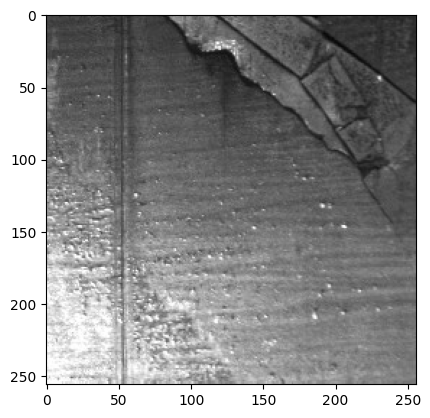

In [110]:
plt.imshow(support_image)

In [111]:
support_image = transform(support_image)
support_mask = resize(support_mask, (352, 352), anti_aliasing=True)
query_image = resize(np.array(query_image), (352, 352), anti_aliasing=True)
query_mask = resize(query_mask, (352, 352), anti_aliasing=True)

s_blend = blend_image_segmentation(support_image, support_mask, mode='crop', image_size=352)
s_blend = s_blend[0].transpose(1,2,0)

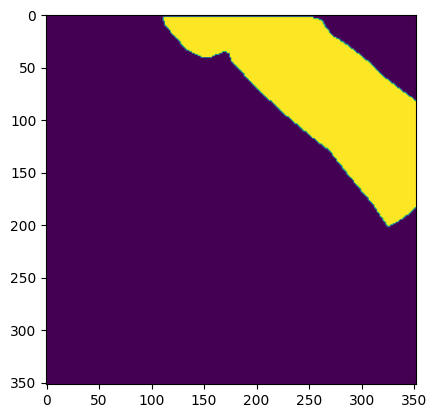

In [112]:
plt.imshow(support_mask)

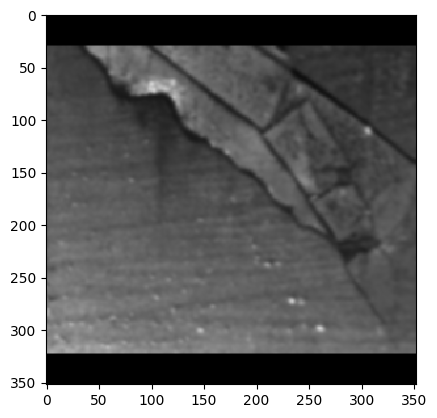

In [113]:
plt.imshow(s_blend)

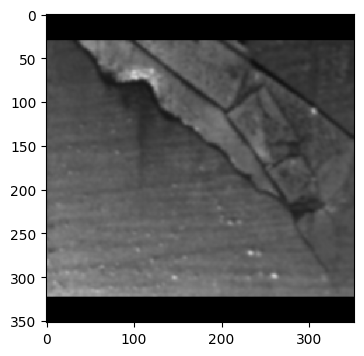

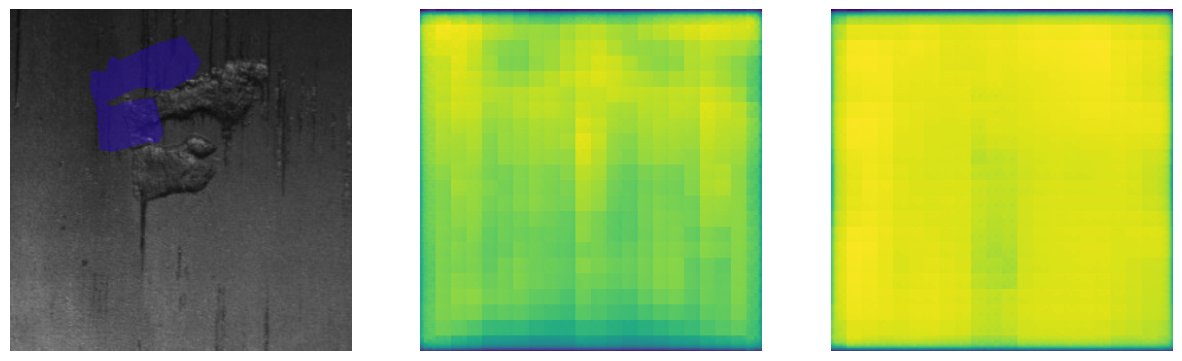

In [114]:
import torch
# predict
encoded_reference = processor(images=[s_blend], return_tensors='pt')
encoded_image = processor(text=[COCO_CLASSES[query_class]], images=[query_image], return_tensors='pt')
encoded_image_no_text = processor(images=[query_image], return_tensors='pt')
with torch.no_grad():
    outputs_only_text = model(**encoded_image)
    outputs = model(**encoded_image_no_text, conditional_pixel_values = encoded_reference.pixel_values)

preds = outputs.logits.unsqueeze(1)
preds = torch.transpose(preds, 0, 1).squeeze(0)
preds_only_text = outputs_only_text.logits.unsqueeze(1)
preds_only_text = torch.transpose(preds_only_text, 0, 1).squeeze(0)
seg_mask = np.array(torch.sigmoid(preds[0]))
seg_mask_only_text = np.array(torch.sigmoid(preds_only_text[0]))
    
_, ax = plt.subplots(1,1, figsize=(4, 4))
ax.imshow(s_blend)

# visualize prediction
anns = metadata.loadAnns(ids=query_id)

_, ax = plt.subplots(1, 3, figsize=(15, 5))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(query_image)
plt.sca(ax[0])
metadata.showAnns(anns, draw_bbox=False)
ax[1].imshow(seg_mask_only_text)
ax[2].imshow(seg_mask)




In [115]:
"""
filenames = [f"mask_{i}.png" for i in range(5)]
result_masks = []
_, ax = plt.subplots(2, 5, figsize=(20, 10))
[a.axis('off') for a in ax.flatten()]
# here we save the second mask
for i, filename in enumerate(filenames):  
    plt.imsave(filename,results[i])
    img = cv2.imread(filename)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, result_mask) = cv2.threshold(gray_image, 132, 255, cv2.THRESH_BINARY)
    _, binary_map_otsu = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    result_masks.append(result_mask)
    ax[0, i].imshow(result_mask, cmap='gray')
    ax[1, i].imshow(binary_map_otsu, cmap='gray')
"""

'\nfilenames = [f"mask_{i}.png" for i in range(5)]\nresult_masks = []\n_, ax = plt.subplots(2, 5, figsize=(20, 10))\n[a.axis(\'off\') for a in ax.flatten()]\n# here we save the second mask\nfor i, filename in enumerate(filenames):  \n    plt.imsave(filename,results[i])\n    img = cv2.imread(filename)\n    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)\n    (thresh, result_mask) = cv2.threshold(gray_image, 132, 255, cv2.THRESH_BINARY)\n    _, binary_map_otsu = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)\n    result_masks.append(result_mask)\n    ax[0, i].imshow(result_mask, cmap=\'gray\')\n    ax[1, i].imshow(binary_map_otsu, cmap=\'gray\')\n'

In [116]:
'''
results_path = f'/home/eas/Enol/clipseg/severstal-steel-defect-detection/results/{target_class}'
dir_name = image_name[0:9]
path = os.path.join(results_path, dir_name)
if not os.path.exists(path):
    os.mkdir(path)

plt.imsave(f'{path}/defect.png',defect)

for i, block in enumerate(blocks_bounded):
    plt.imsave(f'{path}/image_block_{i}.png', block)

for i, result in enumerate(results):
    plt.imsave(f'{path}/heatmap_{i}.png', result)
    
for i, mask in enumerate(result_masks):
    plt.imsave(f'{path}/result_mask_{i}.png', mask)
    
'''

"\nresults_path = f'/home/eas/Enol/clipseg/severstal-steel-defect-detection/results/{target_class}'\ndir_name = image_name[0:9]\npath = os.path.join(results_path, dir_name)\nif not os.path.exists(path):\n    os.mkdir(path)\n\nplt.imsave(f'{path}/defect.png',defect)\n\nfor i, block in enumerate(blocks_bounded):\n    plt.imsave(f'{path}/image_block_{i}.png', block)\n\nfor i, result in enumerate(results):\n    plt.imsave(f'{path}/heatmap_{i}.png', result)\n    \nfor i, mask in enumerate(result_masks):\n    plt.imsave(f'{path}/result_mask_{i}.png', mask)\n    \n"